### Importar librerias

In [ ]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configuración matplotli
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 10, 'lines.linewidth': 1.5})

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

### Importar base de datos 

In [70]:
df_regresion = pd.read_csv('datos/df_regresion.csv')
df_regresion

,codigo_pais,nombre_pais,crecimiento_pob,pib_per_capita,gasto_publico,impuestos
0,AGO,Angola,3.387884,2189.855714,16.684952,10.090386
1,ALB,Albania,-0.426007,5460.428237,22.878406,17.931001
2,ARE,Emiratos Árabes Unidos,1.054516,44251.454139,4.259324,0.972238
3,ARG,Argentina,0.710901,9955.974787,22.036481,10.594398
4,ARM,Armenia,-0.219169,4597.228874,21.758481,22.285171
...,...,...,...,...,...,...
117,UZB,Uzbekistán,1.809744,2041.384807,14.995691,11.301965
118,VUT,Vanuatu,2.330489,3207.446505,27.840881,17.594661
119,WSM,Samoa,1.053292,4351.942349,26.933289,24.427378
120,ZAF,Sudáfrica,1.649575,6533.711210,34.653275,24.867345


### Crear variables para correr el modelo

In [71]:
v_independientes = ['crecimiento_pob', 'pib_per_capita', 'impuestos']
v_dependiente = "gasto_publico"

year = "2019"

### Analizar la correlación entre las variables

In [72]:
# Correlación entre columnas numéricas
# ==============================================================================
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return corr_mat

corr_matrix = df_regresion.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
11,gasto_publico,impuestos,0.683090,0.683090
14,impuestos,gasto_publico,0.683090,0.683090
2,crecimiento_pob,gasto_publico,-0.507073,0.507073
8,gasto_publico,crecimiento_pob,-0.507073,0.507073
9,gasto_publico,pib_per_capita,0.485886,0.485886
6,pib_per_capita,gasto_publico,0.485886,0.485886
1,crecimiento_pob,pib_per_capita,-0.316859,0.316859
4,pib_per_capita,crecimiento_pob,-0.316859,0.316859
3,crecimiento_pob,impuestos,-0.260926,0.260926
12,impuestos,crecimiento_pob,-0.260926,0.260926


### Mapa de calor (Heatmap)

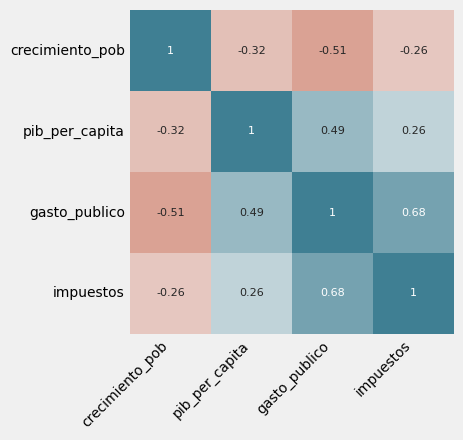

In [73]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

### Analicemos la dispersión de las variables independientes frente a la dependiente

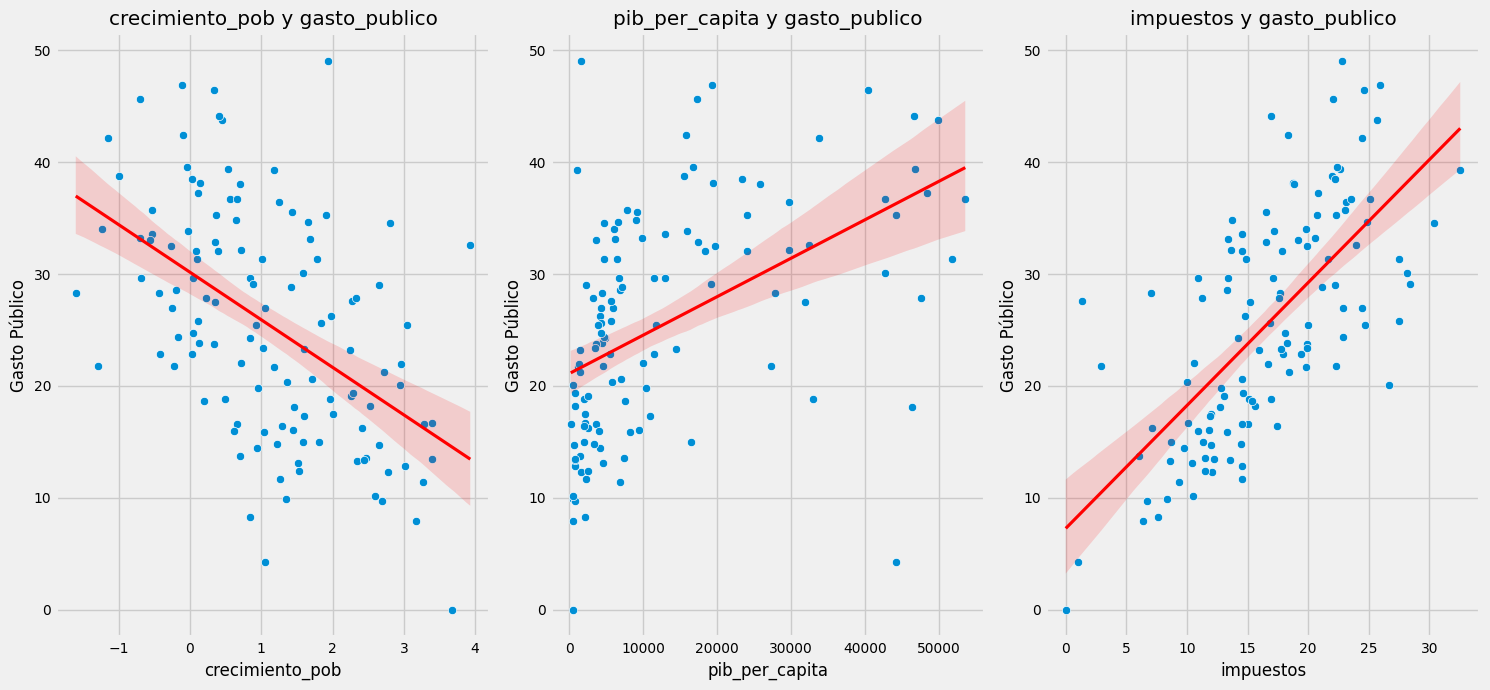

In [74]:
# Gráficos de dispersión entre variables numéricas y pib_per_capita
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

axes = axes.flatten()
for i, var in enumerate(v_independientes):
    sns.scatterplot(
        data=df_regresion,
        x=var,
        y='gasto_publico',
        ax=axes[i]
    )
    sns.regplot(
        data=df_regresion,
        x=var,
        y='gasto_publico',
        ax=axes[i],
        scatter=False,
        color='red'
    )
    axes[i].set_title(f'{var} y gasto_publico')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Gasto Público')

fig.tight_layout()
plt.show()

### División de los datos en train y test

In [75]:
# División de los datos en train y test
# ==============================================================================
X = df_regresion[v_independientes]
y = df_regresion[v_dependiente]
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

### Crear y entrenar el modelo

In [76]:
# Crear y entrenar el modelo
# ==============================================================================
# A la matriz de predictores se le añade una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:          gasto_publico   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     69.57
Date:               vie, 28 mar. 2025   Prob (F-statistic):           1.11e-23
Time:                        16:27:16   Log-Likelihood:                -307.91
No. Observations:                  97   AIC:                             623.8
Df Residuals:                      93   BIC:                             634.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.0984      1.987     

### Diagnosticos de los errores de las predicciones de entrenamiento

In [77]:
prediccion_train = modelo.predict(exog=X_train)
residuos_train   = prediccion_train - y_train

### Multicolinealidad

In [78]:
# Calcular el VIF para cada variable independiente
X = df_regresion[v_independientes]  # Matriz de variables predictoras
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Variable,VIF
0,crecimiento_pob,1.513800
1,pib_per_capita,1.977626
2,impuestos,2.671177


### Independencia de los errores

In [79]:
from statsmodels.stats.stattools import durbin_watson

# Calcular el estadístico de Durbin-Watson
dw_statistic = durbin_watson(residuos_train)
print(f'Estadístico de Durbin-Watson: {dw_statistic}')

Estadístico de Durbin-Watson: 2.063238765129021


### Normalidad de los errores

In [80]:
from scipy.stats import shapiro

# Realizar el test de Shapiro-Wilk
stat, p_value = shapiro(residuos_train)
print(f'Estadístico de Shapiro-Wilk: {stat}, p-value: {p_value}')

# Interpretar el resultado
alpha = 0.05
if p_value > alpha:
  print('No se rechaza la hipótesis nula: los errores se distribuyen normalmente')
else:
  print('Se rechaza la hipótesis nula: los errores no se distribuyen normalmente')

Estadístico de Shapiro-Wilk: 0.9766267770008227, p-value: 0.08080047145607244
No se rechaza la hipótesis nula: los errores se distribuyen normalmente


### Homocedasticidad

In [81]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Realizar el test de Breusch-Pagan
test = het_breuschpagan(residuos_train, X_train)

# Crear un diccionario con los resultados
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
results = dict(zip(labels, test)) 
 
# Interpretar los resultados
alpha = 0.05
if results['p-value'] < alpha:
  print('Se rechaza la hipótesis nula: hay heterocedasticidad.')
else:
  print('No se rechaza la hipótesis nula: no hay heterocedasticidad.')


No se rechaza la hipótesis nula: no hay heterocedasticidad.
